<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#A-PoC-for-calculating-metrics-for-a-city" data-toc-modified-id="A-PoC-for-calculating-metrics-for-a-city-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>A PoC for calculating metrics for a city</a></span><ul class="toc-item"><li><span><a href="#Preprocessing" data-toc-modified-id="Preprocessing-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Preprocessing</a></span></li><li><span><a href="#Check-NaN-columns" data-toc-modified-id="Check-NaN-columns-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Check <code>NaN</code> columns</a></span></li><li><span><a href="#Open-Question:-Impute-NaN-for-daily-tests" data-toc-modified-id="Open-Question:-Impute-NaN-for-daily-tests-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Open Question: Impute <code>NaN</code> for daily tests</a></span></li><li><span><a href="#Find-Levitt-metric" data-toc-modified-id="Find-Levitt-metric-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Find Levitt metric</a></span></li><li><span><a href="#21-day-moving-averages" data-toc-modified-id="21-day-moving-averages-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>21-day moving averages</a></span><ul class="toc-item"><li><span><a href="#MA-of-daily-tests" data-toc-modified-id="MA-of-daily-tests-1.5.1"><span class="toc-item-num">1.5.1&nbsp;&nbsp;</span>MA of daily tests</a></span></li><li><span><a href="#Daily-case-positivity" data-toc-modified-id="Daily-case-positivity-1.5.2"><span class="toc-item-num">1.5.2&nbsp;&nbsp;</span>Daily case positivity</a></span></li><li><span><a href="#Percent-case-growth" data-toc-modified-id="Percent-case-growth-1.5.3"><span class="toc-item-num">1.5.3&nbsp;&nbsp;</span>Percent case growth</a></span></li><li><span><a href="#Impute-Hospitalization-data" data-toc-modified-id="Impute-Hospitalization-data-1.5.4"><span class="toc-item-num">1.5.4&nbsp;&nbsp;</span>Impute Hospitalization data</a></span></li></ul></li><li><span><a href="#Total-active-cases" data-toc-modified-id="Total-active-cases-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Total active cases</a></span></li><li><span><a href="#Save-all-metrics-except-splines-to-CSV" data-toc-modified-id="Save-all-metrics-except-splines-to-CSV-1.7"><span class="toc-item-num">1.7&nbsp;&nbsp;</span>Save all metrics except splines to CSV</a></span></li><li><span><a href="#Create-a-cubic-spline-function" data-toc-modified-id="Create-a-cubic-spline-function-1.8"><span class="toc-item-num">1.8&nbsp;&nbsp;</span>Create a cubic spline function</a></span></li><li><span><a href="#Open-question:-What-do-we-apply-the-spline-function-over?" data-toc-modified-id="Open-question:-What-do-we-apply-the-spline-function-over?-1.9"><span class="toc-item-num">1.9&nbsp;&nbsp;</span>Open question: What do we apply the spline function over?</a></span></li></ul></li></ul></div>

## A PoC for calculating metrics for a city

The metrics would be calculated using the imputation techniques and formulae below for every city

### Preprocessing

We first get the latest data by running the `extract_history.py` script

In [1]:
!python3 extract_history.py

/Users/saurabhjogalekar/swb/swb-venv/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Read the output as a dataframe

In [2]:
import pandas as pd
import numpy as np
from numpy import random

In [3]:
df = pd.read_csv("output/city_stats.csv", index_col=["date"])
df.index = pd.to_datetime(df.index)

We consider only Mumbai for the sake of PoC. The cities would be iterated over in the actual case

In [4]:
df = df[df.district == "Mumbai"]

We now drop the rows that have `NaN` total confirmed cases since all of remaining columns are empty  

In [5]:
df.dropna(subset=["total.confirmed"], inplace=True)

We check if there are any `other` columns 

In [6]:
if not "delta.other" in df.columns:
    df["delta.other"] = 0
if not "total.other" in df.columns:
    df["total.other"] = 0

### Check `NaN` columns

In [7]:
df.isnull().sum()

district             0
state                0
total.confirmed      0
total.deceased       0
total.recovered      0
delta.confirmed      1
delta.deceased       1
delta.recovered      3
delta.tested        53
total.tested        22
delta.other        106
total.other         48
dtype: int64

We see that there are many empty rows for daily tests (delta tests).

### Open Question: Impute `NaN` for daily tests

What is a good strategy to impute NaN for delta tests? We need to ensure that the imputations match the total tests.

Currently, we drop the rows that have empty delta tests.


In [8]:
df.dropna(subset=["delta.tested"], inplace=True)

In [9]:
df.describe()

,total.confirmed,total.deceased,total.recovered,delta.confirmed,delta.deceased,delta.recovered,delta.tested,total.tested,delta.other,total.other
count,87.000000,87.000000,87.000000,87.000000,87.000000,86.000000,87.000000,87.000000,28.000000,77.000000
mean,102496.149425,5499.816092,73918.505747,1214.977011,64.402299,1043.639535,10198.551724,493881.816092,12.142857,228.207792
std,35549.227946,2022.802388,35208.967341,380.570715,95.220730,553.171879,22798.689288,201028.203425,51.738455,131.867192
min,21335.000000,757.000000,3730.000000,-819.000000,20.000000,194.000000,-90542.000000,162000.000000,1.000000,8.000000
25%,78401.500000,4593.500000,44480.500000,1041.000000,39.000000,696.500000,5447.500000,334208.500000,1.000000,11.000000
50%,105923.000000,5930.000000,77102.000000,1190.000000,49.000000,916.000000,7376.000000,462721.000000,2.000000,294.000000
75%,128630.500000,7109.500000,103108.500000,1355.000000,64.000000,1238.000000,10328.000000,654141.500000,4.000000,303.000000
max,163115.000000,8023.000000,128112.000000,2371.000000,917.000000,3139.000000,162000.000000,887274.000000,276.000000,351.000000


We see that there are some rows that have negative values for delta.tested and delta.confirmed. We replace them with the mean of nearest 7 neighbours (1 week)

In [10]:
df.loc[df["delta.tested"]<0, ["delta.tested"]] = np.nan
df.loc[df["delta.confirmed"]<0, ["delta.confirmed"]] = np.nan

In [11]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=7)
df.loc[:,['delta.confirmed', 'delta.tested']] = np.round(imputer.fit_transform(df.loc[:,['delta.confirmed', 'delta.tested']]))

In [12]:
df.describe()

,total.confirmed,total.deceased,total.recovered,delta.confirmed,delta.deceased,delta.recovered,delta.tested,total.tested,delta.other,total.other
count,87.000000,87.000000,87.000000,87.000000,87.000000,86.000000,87.00000,87.000000,28.000000,77.000000
mean,102496.149425,5499.816092,73918.505747,1237.218391,64.402299,1043.639535,11541.91954,493881.816092,12.142857,228.207792
std,35549.227946,2022.802388,35208.967341,310.390355,95.220730,553.171879,20074.19197,201028.203425,51.738455,131.867192
min,21335.000000,757.000000,3730.000000,700.000000,20.000000,194.000000,2671.00000,162000.000000,1.000000,8.000000
25%,78401.500000,4593.500000,44480.500000,1045.500000,39.000000,696.500000,5511.00000,334208.500000,1.000000,11.000000
50%,105923.000000,5930.000000,77102.000000,1190.000000,49.000000,916.000000,7561.00000,462721.000000,2.000000,294.000000
75%,128630.500000,7109.500000,103108.500000,1355.000000,64.000000,1238.000000,10471.00000,654141.500000,4.000000,303.000000
max,163115.000000,8023.000000,128112.000000,2371.000000,917.000000,3139.000000,162000.00000,887274.000000,276.000000,351.000000


### Find Levitt metric

We first shift the deceased cases and apply log 

In [13]:
df["total.deceased.shift"] = df["total.deceased"].shift(1)

In [14]:
import numpy as np
df["levitt.Metric"] = np.log(df["total.deceased"]/df.pop("total.deceased.shift"))

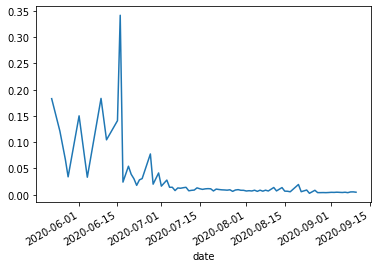

In [15]:
df["levitt.Metric"].plot()

Sharp spike due to 800+ deaths in a day, which was an outlier for that time 

### 21-day moving averages

#### MA of daily tests

In [16]:
df["MA.21.daily.tests"] = df["delta.tested"].rolling(window=21).mean()

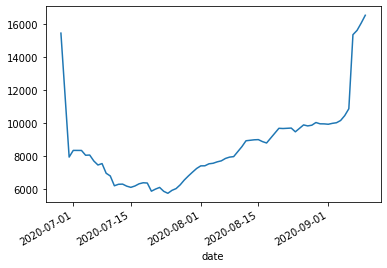

In [17]:
df["MA.21.daily.tests"].plot()

#### Daily case positivity

We find daily positivity by dividing daily confirmed cases by the number of tests

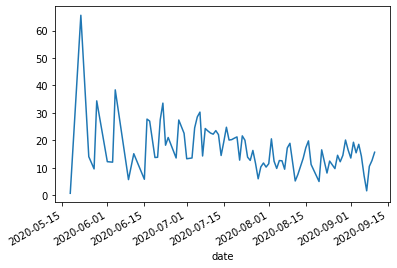

In [18]:
df["delta.positivity"] = (df["delta.confirmed"]/df["delta.tested"] ) * 100.0
df["delta.positivity"].plot()

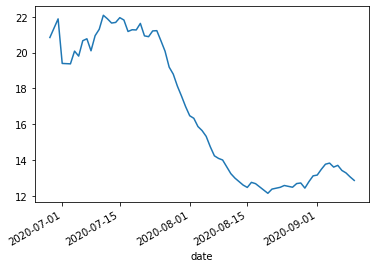

In [19]:
df["MA.21.delta.positivity"] = df["delta.positivity"].rolling(window=21).mean()
df["MA.21.delta.positivity"].plot()

#### Percent case growth



In [20]:
df["delta.percent.case.growth"] = df["delta.confirmed"].pct_change()

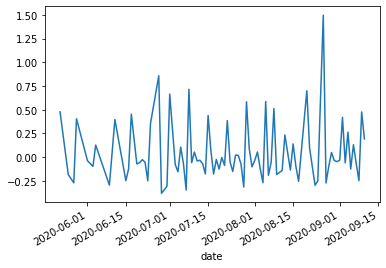

In [21]:
df["delta.percent.case.growth"].plot()

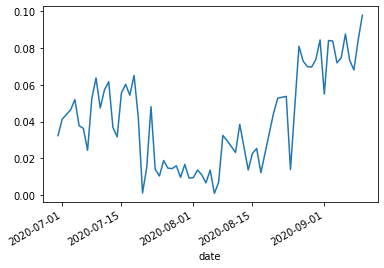

In [22]:
df["MA.21.delta.percent.case.growth"] = df["delta.percent.case.growth"].rolling(window=21).mean()
df["MA.21.delta.percent.case.growth"].plot()

#### Impute Hospitalization data

We calculate values from 12% to 16% uniformly and store them in a file for persistence and consistency

In [23]:
# this code is used to generate random values and store them in a file with corresponding percentage for dates
# uncomment to reset the percentages

#from numpy import random
#df["percentages"] = random.uniform(0.12,0.16,size=df.shape[0])
#df_bck = pd.DataFrame(df["percentages"], index=df.index)
#df_bck.to_csv("output/percentages_for_hospitalizations.csv")
#df.drop(["percentages"], axis=1, inplace=True)

In [24]:
#df.drop(["percentages"], axis=1, inplace=True)
df_bck = pd.read_csv("output/percentages_for_hospitalizations.csv", index_col=["date"])
df = df.join(df_bck)

In [25]:
if sum(np.isnan(df["percentages"])) > 0:
    imp = pd.Series(random.uniform(0.12,0.16,size=sum(np.isnan(df["percentages"]))))
    df.loc[np.isnan(df["percentages"]),["percentages"]] = imp[0]
    df_bck = pd.DataFrame(df["percentages"], index=df.index)
    df_bck.to_csv("output/percentages_for_hospitalizations.csv")

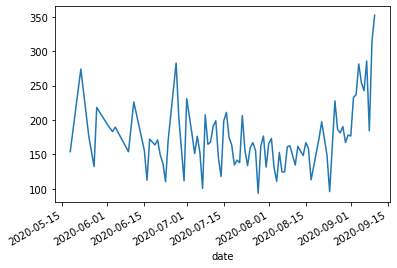

In [26]:
df["delta.hospitalized"] = df.pop("percentages") * df["delta.confirmed"]
df["delta.hospitalized"].plot()

In [27]:
df["total.hospitalized"] = df["delta.hospitalized"].cumsum()

### Total active cases

We find active cases by:

Active = Confirmed - deceased - recovered

In [28]:
df["delta.active"] = df["total.confirmed"] - df["total.deceased"] - df["total.recovered"] 

### Save all metrics except splines to CSV

In [29]:
df.to_csv("output/metrics.csv")

### Create a cubic spline function

Create a function for cubic spline using delta(daily) cases as parameters.

In [30]:
y = df.loc[:,["delta.deceased", "delta.active", "delta.hospitalized", "delta.recovered"]]
y.dropna(inplace=True)

In [31]:
from scipy.interpolate import CubicSpline

In [33]:
cs = CubicSpline(y.index.astype(int), y)

### Open question: What do we apply the spline function over?